In [16]:
import gtfs_kit as gk
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Read gtfs3Sept.zip
file3s = Path('/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/gtfs/gtfs3Sept.zip')
feed3s = (gk.read_feed(file3s, dist_units='m'))
feed3s.validate()

,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]


In [4]:
# Read gtfs23Sept.zip
file23s = Path('/home/jose/Desktop/Lorenc1o-repos/DataMining_HackMyRide/schedule/gtfs/gtfs23Sept.zip')
feed23s = (gk.read_feed(file23s, dist_units='m'))
feed23s.validate()

,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]


In [4]:
# Our data goes from 2021-09-05 to 2021-09-21
print(gk.calendar.get_week(feed3s, 3))
print(gk.calendar.get_week(feed3s, 4))
print(gk.calendar.get_week(feed3s, 5))
print(gk.calendar.get_week(feed23s, 1)[:2])
print(gk.calendar.get_dates(feed3s))
# As we can see, we need both feeds to get the whole schedule, so we'll merge them

['20210906', '20210907', '20210908', '20210909', '20210910', '20210911', '20210912']
['20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919']
[]
['20210920', '20210921']
['20210823', '20210824', '20210825', '20210826', '20210827', '20210828', '20210829', '20210830', '20210831', '20210901', '20210902', '20210903', '20210904', '20210905', '20210906', '20210907', '20210908', '20210909', '20210910', '20210911', '20210912', '20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919']


In [27]:
# Get all dates matching our data
our_dates = {}
our_dates['3s'] = gk.calendar.get_week(feed3s, 3)
our_dates['3s'].extend(gk.calendar.get_week(feed3s, 4))
our_dates['23s'] = gk.calendar.get_week(feed23s, 1)[:2]
print(our_dates)

# Get all lines
lines = {}
lines['3s'] = gk.routes.get_routes(feed3s)
lines['23s'] = gk.routes.get_routes(feed23s)
print(lines['3s'].route_id.unique())

{'3s': ['20210906', '20210907', '20210908', '20210909', '20210910', '20210911', '20210912', '20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919'], '23s': ['20210920', '20210921']}
['2' '4' '5' '10' '1' '3' '6' '11' '12' '18' '20' '21' '22' '13' '23' '19'
 '25' '93' '27' '28' '29' '76' '32' '34' '35' '37' '39' '41' '43' '45'
 '36' '40' '44' '30' '47' '48' '49' '50' '15' '31' '52' '53' '26' '54'
 '55' '56' '57' '58' '59' '9' '60' '62' '63' '64' '17' '38' '65' '66' '98'
 '51' '68' '69' '70' '71' '72' '61' '42' '14' '16' '91' '73' '46' '89'
 '24' '74' '90' '33' '7' '75' '77' '8' '67' '95' '96' '97' '94' '78' '80'
 '79' '82' '81' '83' '85' '84' '86' '92' '87' '88']


In [102]:
timetable_2 = gk.routes.build_route_timetable(feed3s, '2', dates=['20210906'])
print(timetable_2)

        route_id service_id             trip_id    trip_headsign  \
1787251        2  236270000  112949860236270000  GARE DE L'OUEST   
1787252        2  236270000  112949860236270000  GARE DE L'OUEST   
1787253        2  236270000  112949860236270000  GARE DE L'OUEST   
1787254        2  236270000  112949860236270000  GARE DE L'OUEST   
1787255        2  236270000  112949860236270000  GARE DE L'OUEST   
...          ...        ...                 ...              ...   
1781427        2  236270000  112949570236270000          STOCKEL   
1781428        2  236270000  112949570236270000          STOCKEL   
1781429        2  236270000  112949570236270000          STOCKEL   
1781430        2  236270000  112949570236270000          STOCKEL   
1781431        2  236270000  112949570236270000          STOCKEL   

         direction_id block_id  shape_id arrival_time departure_time stop_id  \
1787251             1  8912837  001m0063     05:17:53       05:17:53    8151   
1787252             1  

In [25]:
for key in lines:
    rids = lines[key].route_id.unique()
    for rid in rids:
        for date in our_dates[key]:
            # Get timetable for route_id rid and day date
            if key == '3s':
                timetable = gk.routes.build_route_timetable(feed3s, rid, [date])
            else:
                timetable = gk.routes.build_route_timetable(feed23s, rid, [date])
            # Save to csv
            timetable.to_csv(f'./schedules_day/schedule_{rid}_{date}.csv')

KeyboardInterrupt: 

In [7]:
# Get timetable for line 71 (route_id = 65)
timetable = gk.routes.build_route_timetable(feed3s,'65',['20210906'])
# Reorder timeline:
# first by direction_id
# then by stop
# then by departure_time
timetable = timetable.sort_values(by=['direction_id','stop_sequence','departure_time'])
print(timetable)

        route_id service_id             trip_id trip_headsign  direction_id  \
1449230       65  236683000  113071172236683000         DELTA             0   
1442390       65  236683000  113070830236683000         DELTA             0   
1442651       65  236683000  113070843236683000         DELTA             0   
1442990       65  236683000  113070860236683000         DELTA             0   
1448952       65  236683000  113071158236683000         DELTA             0   
...          ...        ...                 ...           ...           ...   
1444646       65  236683000  113070942236683000  DE BROUCKERE             1   
1445404       65  236683000  113070980236683000  DE BROUCKERE             1   
1448124       65  236683000  113071116236683000  DE BROUCKERE             1   
1446044       65  236683000  113071012236683000  DE BROUCKERE             1   
1443368       65  236683000  113070878236683000  DE BROUCKERE             1   

        block_id  shape_id arrival_time departure_t

In [33]:
# save timetable to csv
timetable.to_csv('./schedules_day/schedule_65_20210906.csv')

In [96]:
# Function to compute difference of two hours in format 0 to infinity
def date_diff(df1:pd.Series, df2:pd.Series):
    diff = []
    for i in range(len(df1)):
        # Get current hours
        hour1 = df1.iloc[i]
        hour2 = df2.iloc[i]
        if hour1 is None or hour2 is None:
            diff.append(-999)
            continue
        # Compute difference in seconds
        h1 = hour1.split(':')
        h2 = hour2.split(':')
        diff.append((int(h1[0])*3600 + int(h1[1])*60 + int(h1[2])) - (int(h2[0])*3600 + int(h2[1])*60 + int(h2[2])))
    return diff

In [90]:
print(date_diff(pd.Series(['12:00:00']), pd.Series(['11:00:00']))) # 3600
print(date_diff(pd.Series(['26:16:00']), pd.Series(['23:00:00']))) # 11760
print(date_diff(pd.Series(['26:16:00']), pd.Series([None])))


[3600]
[11760]
[-999]


In [104]:
print(timetable.columns)
reduced_timetable = timetable[['trip_headsign','direction_id', 'stop_id','departure_time']]
# Compute the headways
# by subtracting the departure time of the current stop to the departure time of the previous stop
# using our function date_diff
series = reduced_timetable['departure_time']
series2 = reduced_timetable['departure_time'].shift(periods=1)
reduced_timetable['headway'] = date_diff(series, series2)

Index(['route_id', 'service_id', 'trip_id', 'trip_headsign', 'direction_id',
       'block_id', 'shape_id', 'arrival_time', 'departure_time', 'stop_id',
       'stop_sequence', 'pickup_type', 'drop_off_type', 'date'],
      dtype='object')


/tmp/ipykernel_19493/1858567705.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_timetable['headway'] = date_diff(series, series2)


In [109]:
# Function to identify regularity or punctuality
def identify(row):
    if row['headway'] > 0 and row['headway'] < 60*12:
        return 'regularity'
    else:
        return 'punctuality'

In [110]:
# use the identify function to create a new column
reduced_timetable['regularity'] = reduced_timetable.apply(identify, axis=1)
# save reduced timetable to csv
reduced_timetable.to_csv('./schedules_day/schedule_65_20210906_reduced.csv')

/tmp/ipykernel_19493/160871758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_timetable['regularity'] = reduced_timetable.apply(identify, axis=1)


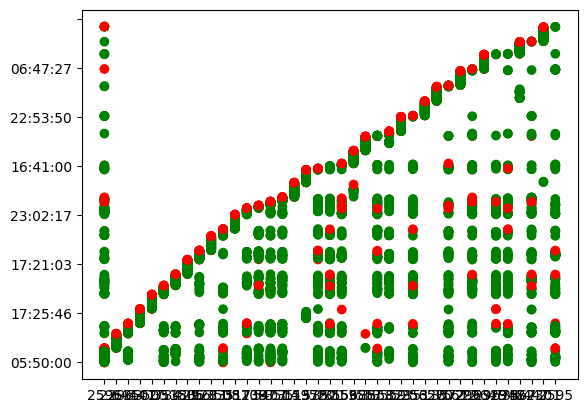

In [130]:
# Visualize the headways:
# plot the headways for each direction
# the x axis are the stops
# the y axis are the headways
# the color of the line is the regularity or punctuality

for direction in reduced_timetable.direction_id.unique():
    df = reduced_timetable[reduced_timetable.direction_id == direction]
    # show only positive headways
    df = df[df['headway'] > 0]
    colors = df['regularity'].apply(lambda x: 'green' if x == 'regularity' else 'red')
    # show an horizontal line at 12*60 = 720 seconds
    # plt.axhline(y=720, color='black', linestyle='--')
    # in the y axis, don't show all the values, bin them in 10
    plt.yticks(np.arange(0, 7200, 600))
    plt.scatter(df['stop_id'], df['departure_time'], c=colors)
    


        trip_headsign  direction_id stop_id departure_time  headway  \
1442389  DE BROUCKERE             1    2596       05:22:00   -68340   
1449269  DE BROUCKERE             1    2596       05:41:00     1140   
1442650  DE BROUCKERE             1    2596       05:56:00      900   
1448783  DE BROUCKERE             1    2596       06:06:00      600   
1443408  DE BROUCKERE             1    2596       06:14:00      480   
...               ...           ...     ...            ...      ...   
1444646  DE BROUCKERE             1    2596       23:35:00      660   
1445404  DE BROUCKERE             1    2596       23:47:00      720   
1448124  DE BROUCKERE             1    2596       23:59:00      720   
1446044  DE BROUCKERE             1    2596       24:11:00      720   
1443368  DE BROUCKERE             1    2596       24:23:00      720   

          regularity  
1442389  punctuality  
1449269  punctuality  
1442650  punctuality  
1448783   regularity  
1443408   regularity  
...      

<BarContainer object of 177 artists>

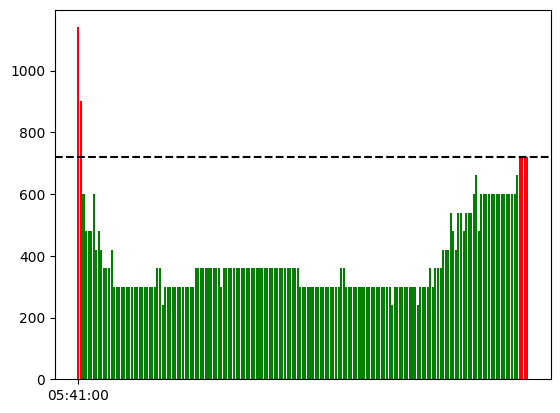

In [141]:
# Visualize the headways:
# plot the headways on one stop in one direction: stop_id = 2596, direction_id = 1
# the x axis is the departure_time
# the y axis is the headways
# the color of the line is the regularity or punctuality
stop_id = '2596'
direction_id = 1
df = reduced_timetable.loc[(reduced_timetable.direction_id == direction_id) & (reduced_timetable.stop_id == stop_id)]
print(df)
# show only positive headways
df = df[df['headway'] > 0]
colors = df['regularity'].apply(lambda x: 'green' if x == 'regularity' else 'red')
# show an horizontal line at 12*60 = 720 seconds
plt.axhline(y=720, color='black', linestyle='--')
# in the x axis, don't show all the values, bin them in 10
plt.xticks(np.arange(0, 86400, 3600))
# Show as bar plot
plt.bar(df['departure_time'], df['headway'], color=colors)

None


In [89]:
# Function to compute difference of two hours in format 0 to infinity
def date_diff(df1:pd.Series, df2:pd.Series):
    diff = []
    for i in range(len(df1)):
        # Get current hours
        hour1 = df1.iloc[i]
        hour2 = df2.iloc[i]
        if hour1 is None or hour2 is None:
            diff.append(-999)
            continue
        # Compute difference in seconds
        h1 = hour1.split(':')
        h2 = hour2.split(':')
        diff.append((int(h1[0])*3600 + int(h1[1])*60 + int(h1[2])) - (int(h2[0])*3600 + int(h2[1])*60 + int(h2[2])))
    return diff
    
# Function to identify regularity or punctuality
def identify(row):
    if row['headway'] > 0 and row['headway'] < 60*12:
        return 'regularity'
    else:
        return 'punctuality'

def classify(df):
    # returns a df with column 'class':
    # if in df['candidate'] we find:
    # one 'regularity' between two 'punctuality' -> 'punctuality'
    # two 'regularity' between two 'punctuality' -> 'punctuality'
    # otherwise, same value as 'candidate'
    class_ = []
    counter = 0
    length = len(df)
    for i in range(length):
        if df.iloc[i]['candidate'] == 'punctuality':
            counter = 0
            class_.append('punctuality')
        else:
            if counter > 1:
                class_.append('regularity')
            elif counter == 1:
                if i < length - 1:
                    if df.iloc[i+1]['candidate'] == 'regularity':
                        class_.append('regularity')
                    else:
                        class_.append('punctuality')
            else:
                if i < length - 2:
                    if df.iloc[i+1]['candidate'] == 'regularity' and df.iloc[i+2]['candidate'] == 'regularity':
                        class_.append('regularity')
                    else:
                        class_.append('punctuality')
                else:
                    class_.append('punctuality')
            counter += 1
    df['class'] = class_
    return df
        
def process_line(line='65', feed=feed3s, day=['20210906']):
    #timetable = gk.routes.build_route_timetable(feed3s,line,day)
    timetable = gk.routes.build_route_timetable(feed,line,day)
    # Reorder timeline:
    # first by direction_id
    # then by stop
    # then by departure_time
    timetable = timetable.sort_values(by=['direction_id','stop_sequence','departure_time'])
    reduced_timetable = timetable[['trip_headsign','direction_id', 'stop_id','departure_time']]
    # Compute the headways
    # by subtracting the departure time of the current stop to the departure time of the previous stop
    # using our function date_diff
    series = reduced_timetable['departure_time']
    series2 = reduced_timetable['departure_time'].shift(periods=1)
    reduced_timetable['headway'] = date_diff(series, series2)
    # use the identify function to create a new column
    reduced_timetable['candidate'] = reduced_timetable.apply(identify, axis=1)
    # use the classify function to create a new column
    reduced_timetable = classify(reduced_timetable)

    return reduced_timetable

def show_headways(stop_id, timetable, direction_id=1):
    df = timetable.loc[(timetable.direction_id == direction_id) & (timetable.stop_id == stop_id)]
    # show only positive headways
    df = df[df['headway'] > 0]
    colors = df['class'].apply(lambda x: 'green' if x == 'regularity' else 'red')

    # show an horizontal line at 12*60 = 720 seconds
    plt.axhline(y=720, color='black', linestyle='--')
    # in the x axis, don't show all the hours, bin them in 10
    plt.xticks(np.arange(0, 36000, 3600))
    # Show as bar plot
    plt.bar(df['departure_time'], df['headway'], color=colors)
    # Add legend:
    # line = 12 minutes
    # green = regularity
    # red = punctuality
    handles = [plt.Rectangle((0,0),1,1, color='green'), plt.Rectangle((0,0),1,1, color='red')]
    plt.legend(handles, ['regularity', 'punctuality'])


/tmp/ipykernel_51763/3467262704.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_timetable['headway'] = date_diff(series, series2)
/tmp/ipykernel_51763/3467262704.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_timetable['candidate'] = reduced_timetable.apply(identify, axis=1)
/tmp/ipykernel_51763/3467262704.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

        trip_headsign  direction_id stop_id departure_time  headway  \
1263206          BUDA             0   1474B       05:16:00     -999   
1264355          BUDA             0    2299       05:25:00      540   
1262465          BUDA             0   1474B       05:40:00      900   
1262407          BUDA             0   1474B       06:00:00     1200   
1262378          BUDA             0   1474B       06:20:00     1200   
...               ...           ...     ...            ...      ...   
1263063       SCHUMAN             1   1474B       22:54:00     1260   
1263177       SCHUMAN             1   1474B       23:13:00     1140   
1263205       SCHUMAN             1   1474B       23:33:00     1200   
1262867       SCHUMAN             1   1474B       23:53:00     1200   
1262895       SCHUMAN             1   1474B       24:13:00     1200   

           candidate        class  
1263206  punctuality  punctuality  
1264355   regularity  punctuality  
1262465  punctuality  punctuality  
126

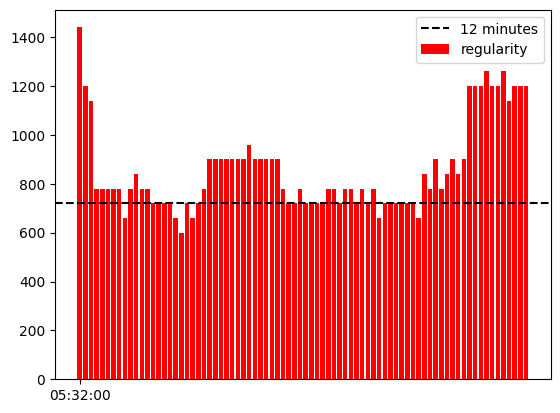

In [71]:
tt = process_line('54', feed3s, ['20210906'])
print(tt)
# get some stop_id from the timetable
stop_id = tt.stop_id.unique()[0]
show_headways(stop_id, tt, direction_id=1)

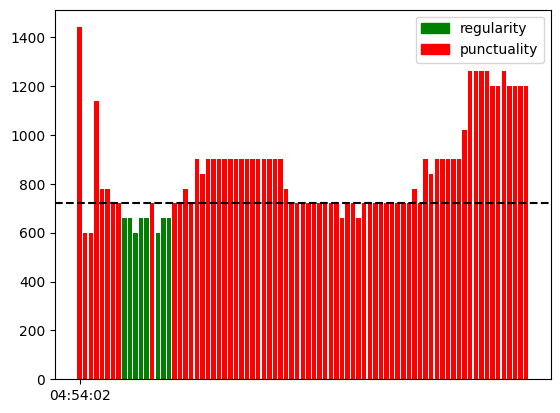

In [90]:

show_headways('1838', tt, direction_id=1)

In [46]:
print(tt['stop_id'].unique())

['1474B' '2299' '2083' '1967' '2068' '2095' '6082' '2093' '6190' '1989'
 '9296' '2365' '2106' '2827' '2051' '2829B' '3451' '1827' '3412' '1837'
 '2101' '1992' '6303B' '2378' '2098' '2898' '6459' '2367' '6370' '2379'
 '1991' '1838' '1839' '2352' '2823B' '2766' '1987' '2092' '2094' '1974'
 '2377' '6368C' '2096' '6461' '5740' '2097' '6364B' '2100' '2102' '3414'
 '2067' '2105' '9291' '6191' '2920' '1273']
